In [312]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from imblearn.over_sampling import RandomOverSampler

import spacy
from spacy.tokens import DocBin
from spacy.training import Example

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [355]:
RANDOM_STATE = 7

### Clear data

In [148]:
# Load and save data
df = pd.read_csv("data/Aboutlabeled.csv")
df = df.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'],  axis=1)

# index of incorrect labels
incorrect_labels_index = df[(df['Label'] != 'About') & (df['Label'] != 'None')].index
# delete empty and incorrect rows
df.drop(index=incorrect_labels_index, axis=0, inplace=True)
df.dropna(axis=0, how='any', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16652 entries, 0 to 16720
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     16652 non-null  object
 1   Label    16652 non-null  object
 2   ID       16652 non-null  object
 3   Offsets  16652 non-null  object
dtypes: object(4)
memory usage: 650.5+ KB


In [149]:
df.head()

,Text,Label,ID,Offsets
0,Funding Circle was created with a big idea:,None,article_00000.pre.xmi:001,[]
1,To revolutionize the outdated banking system a...,About,article_00000.pre.xmi:002,[{u'text': u'revolutionize the outdated bankin...
2,"Thousands of loans later, we've helped busines...",About,article_00000.pre.xmi:003,"[{u'text': u'we', u'endOffset': 28, u'beginOff..."
3,We've taken this progress global.,About,article_00000.pre.xmi:004,"[{u'text': u'We', u'endOffset': 2, u'beginOffs..."
4,Funding Circle is the world's leading marketpl...,About,article_00000.pre.xmi:005,"[{u'text': u'Funding Circle', u'endOffset': 14..."


### Prepare data

In [500]:
# Prepare X
X = df['Text']
# Prepare labels
y = df['Label'].map({'None': 0, 'About': 1})


In [488]:
X[0]

'Funding Circle was created with a big idea:'

In [502]:
%%time

# Preprocessing data
nlp = spacy.load('en_core_web_sm')

# Remove spaces
X = [string.strip() for string in X]

# Preprocessing text
docs = nlp.pipe(X)
X = list()

for doc in tqdm(docs):
    # Delete stop words
    words = [token.text for token in doc if not token.is_stop]
#     words = [token.lemma_ for token in words]
    X.append(' '.join(words))

0it [00:00, ?it/s]

CPU times: user 25.9 s, sys: 4.52 s, total: 30.5 s
Wall time: 30.7 s


In [463]:
list(docs)

[]

### Split data and aversample train data

In [503]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  train_size = 0.7, 
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)
# Split X_val, y_val into validation and test data
X_val, X_test, y_val, y_test = train_test_split(X_val, 
                                                y_val, 
                                                train_size = 0.7, 
                                                shuffle=True,
                                                random_state=RANDOM_STATE)

In [504]:
pd.Series(y_train).value_counts()

0    10367
1     1289
Name: Label, dtype: int64

In [505]:
# Create OverSampler and resample X, y train
X_train, y_train = oversample.fit_resample(pd.DataFrame(X_train), y = y_train)
X_train = [i[0] for i in X_train.values.tolist()]
pd.Series(y_train).value_counts()

1    10367
0    10367
Name: Label, dtype: int64

### Functions for scores

In [354]:
# Function for print main metrics for prediction
def print_scores(y_val, y_pred, threshold=0.5):
    
    # Rounding the prediction with the select threshold
    th_y_pred = np.where(np.array(y_pred) > threshold, 1, 0)
    
    # Print scores
    acc_score = accuracy_score(y_val, th_y_pred)
    pr_score, re_score, f_score, _ = precision_recall_fscore_support(y_val, 
                                                                     th_y_pred, 
                                                                     average='binary')
    print(f"Accuracy score: {round(acc_score, 3)}")
    print(f"Precision score: {round(pr_score, 3)}")
    print(f"Recall score: {round(re_score, 3)}")
    print(f"F-score: {round(f_score, 3)}")
    
    # Calculate F1-Score for the thresholds
    f_scores = list()
    thresholds = np.linspace(0, 1, 100)
    
    for step in thresholds:
        th_y_pred = np.where(np.array(y_pred) > step, 1, 0)
        _, _, f_score, _ = precision_recall_fscore_support(y_val,
                                                           th_y_pred,
                                                           average='binary')
        f_scores.append(f_score)
    
    # Drawing F1-Score for the thresholds
    ax = sns.lineplot(x=thresholds, y=f_scores)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1-Score')
    
    # Print the best F1-Score and the appropriate threshold
    print(f"\nMax F1-Score: {round(np.max(f_scores), 3)} (threshold: {round(thresholds[np.argmax(f_scores)], 3)})\n")

    
# Function for drawing a history graphs from NNs
def plot_history_nn(history, combined_keys=None, calculate_f1_score=False):
    """
    Takes a history object from NN and plots all metrics.
    
    Parameters
    ----------
    history : history.history object what NN.fit returns
    combined_keys : array_like
        If neen to combine several metrics in one window.
        Metrics contained in the same list like:
        combined_keys=[[metric1, metric2, metric3], [metric4]] 
        will be drawn in one window (metric1-3)
    calculate_f1_score : Boolean
        Will calculate the F1-Score for each epoch.
        For "combined_keys" use the "val_f1_score" key
    """
    # Calculate F1-Score for all epochs if calculate_f1_score == True
    if calculate_f1_score:
        precision = np.array(history['val_precision'])
        recall = np.array(history['val_recall'])
        history['val_f1_score'] = 2 * ((precision * recall) / (precision + recall))
        # Replace np.nan to zero
        history['val_f1_score'] = np.nan_to_num(history['val_f1_score'])
    
    # Check if uses without combined_keys
    if not combined_keys:
        keys = list(history.keys())
        # Raise error if number of metrics not a pair
        if len(keys) % 2 != 0:
            raise ValueError("History object doesn't have a pair number of keys")
        x = list(range(len(history[keys[0]])))
    else:
        keys = list(combined_keys)
        # Check for each element of combined_keys that it is a list
        for key in keys:
            if type(key) != list:
                raise ValueError(f"Element:'{key}' is not a list")
        x = list(range(len(history[keys[0][0]])))
    
    # Prepare windows
    rows  = int(np.ceil(len(keys) / 2))
    _, axs = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    
    # Draw metrics
    for i, key in enumerate(keys):
        indx=np.unravel_index(i, shape=axs.shape)
        
        if combined_keys:
            for inter_key in key:
                sns.lineplot(x=x, y=history[inter_key], ax=axs[indx], label=inter_key)
        else:
            sns.lineplot(x=x, y=history[key], ax=axs[indx], label=key)
        axs[indx].set_xlabel("Epoch")
    
    # Print the best results for each metric
    for key in history.keys():
        # Save min/max results
        min_res = str(round(np.min(history[key]), 3))
        max_res = str(round(np.max(history[key]), 3))
        # Find the appropriate epoch for min/max results
        epoch_min_res = np.argmin(history[key]) + 1
        epoch_max_res = np.argmax(history[key]) + 1
        
        indent = ' ' * (15 - len(key))
        
        print(f"{key}: {indent} min-{min_res}({epoch_min_res} epoch), \t max-{max_res}({epoch_max_res} epoch)")



    
    

# Version 1: Training the Spacy model with examples and nlp.update

In [244]:
# Return the label prediction for text list
def nlp_cats_predict(text_list, label, nlp):

    y_pred = []

    for doc in nlp.pipe(text_list):
        y_pred.append(doc.cats[label])
    
    return y_pred

In [292]:
# 
def train_model(X_train, X_val, y_train, y_val, labels = ['pos', 'neg'], epochs=10, nlp=None):
    # Create a new nlp if not given
    if not nlp:
        nlp = spacy.load('en_core_web_sm')
        print('New NLP load')
    
    # Add textcat in pipeline
    if 'textcat' not in nlp.pipe_names:
#         textcat = nlp.create_pipe("textcat", config={"architecture": "simple_cnn"})
        textcat = nlp.add_pipe('textcat', last=True)
    else:
        textcat = nlp.get_pipe('textcat')
    # Add labels
    textcat.add_label(labels[0])
    textcat.add_label(labels[1])
    
    # Prepare train and validation data
    # The dictionary with the key "cats" requires for the Example object
    data_train = list(zip(X_train, ({'cats': {labels[0]: i == 1, labels[1]: i == 0}} for i in y_train)))
#     data_val = list(zip(X_val, ({'cats': {labels[0]: i == 1, labels[1]: i == 0}} for i in y_val)))
    
    # History dictionary with results for validation data
    history = {'val_accuracy': list(),
               'val_precision': list(),
               'val_recall': list(),
               'val_f1_score': list()}
    
    # Disable pipes
    disable_pipes_list = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
    
    # Training
    with nlp.disable_pipes(disable_pipes_list):
        optimizer = nlp.begin_training()
        batches_size = spacy.util.compounding(4.0, 256.0, 2.001)
        
        for epoch in range(epochs):
            loss = {}
            data_train = utils.shuffle(data_train)
            batches = spacy.util.minibatch(data_train, size=batches_size)
            print(f"Epoch: {epoch + 1}/{epochs} {'-' * 70}")
            
            for batch in tqdm(batches):
                examples = [Example.from_dict(nlp(i[0]), i[1]) for i in batch]
                nlp.update(examples, drop=0.2, sgd=optimizer, losses=loss)
            
            
            # Saves scores validation data
            y_pred = nlp_cats_predict(X_val, labels[0], nlp)
            
            ac_score = accuracy_score(y_val, np.round(y_pred))
            pr_score, re_score, f_score, _ = precision_recall_fscore_support(y_val, 
                                                                             np.round(y_pred), 
                                                                             average='binary')
            history['val_accuracy'].append(ac_score)
            history['val_precision'].append(pr_score)
            history['val_recall'].append(re_score)
            history['val_f1_score'].append(f_score)
            
            print(f"Val_accuracy: {round(ac_score, 3)}, F1-Score: {round(f_score, 3)}")
            

    return nlp, history



In [506]:
%%time

nlp = spacy.load('en_core_web_sm')

nlp, history = train_model(X_train, 
                           X_val, 
                           y_train, 
                           y_val, 
                           labels=['About', 'None'],
                           epochs = 10,
                           nlp=nlp)

Epoch: 1/10 ----------------------------------------------------------------------


0it [00:00, ?it/s]

Val_accuracy: 0.812, F1-Score: 0.483
Epoch: 2/10 ----------------------------------------------------------------------


0it [00:00, ?it/s]

Val_accuracy: 0.799, F1-Score: 0.475
Epoch: 3/10 ----------------------------------------------------------------------


0it [00:00, ?it/s]

Val_accuracy: 0.874, F1-Score: 0.536
Epoch: 4/10 ----------------------------------------------------------------------


0it [00:00, ?it/s]

Val_accuracy: 0.843, F1-Score: 0.508
Epoch: 5/10 ----------------------------------------------------------------------


0it [00:00, ?it/s]

Val_accuracy: 0.856, F1-Score: 0.503
Epoch: 6/10 ----------------------------------------------------------------------


0it [00:00, ?it/s]

Val_accuracy: 0.877, F1-Score: 0.516
Epoch: 7/10 ----------------------------------------------------------------------


0it [00:00, ?it/s]

Val_accuracy: 0.867, F1-Score: 0.508
Epoch: 8/10 ----------------------------------------------------------------------


0it [00:00, ?it/s]

Val_accuracy: 0.888, F1-Score: 0.528
Epoch: 9/10 ----------------------------------------------------------------------


0it [00:00, ?it/s]

Val_accuracy: 0.88, F1-Score: 0.492
Epoch: 10/10 ----------------------------------------------------------------------


0it [00:00, ?it/s]

Val_accuracy: 0.889, F1-Score: 0.502
CPU times: user 8min 6s, sys: 16.9 s, total: 8min 23s
Wall time: 8min 26s


Accuracy score: 0.889
Precision score: 0.524
Recall score: 0.481
F-score: 0.502

Max F1-Score: 0.529 (threshold: 0.121)



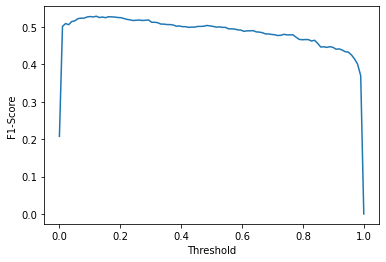

In [507]:
y_pred = nlp_cats_predict(X_val, 'About', nlp)
print_scores(y_val, y_pred)

val_accuracy:     min-0.799(2 epoch), 	 max-0.889(10 epoch)
val_precision:    min-0.34(2 epoch), 	 max-0.524(10 epoch)
val_recall:       min-0.481(10 epoch), 	 max-0.785(2 epoch)
val_f1_score:     min-0.475(2 epoch), 	 max-0.536(3 epoch)


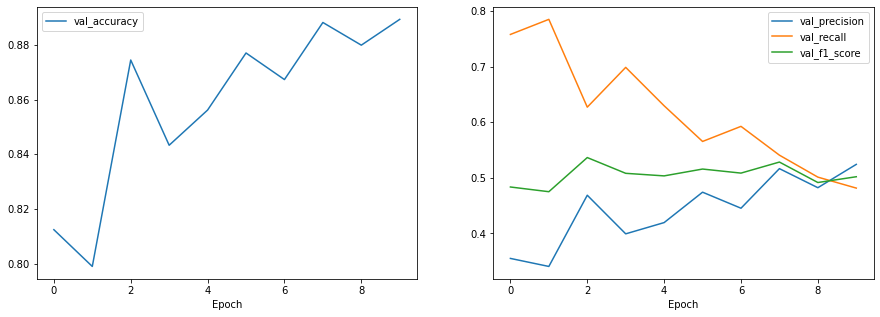

In [508]:
plot_history_nn(history, 
                combined_keys=[['val_accuracy'], 
                               ['val_precision', 'val_recall', 'val_f1_score']])

#### *F1-Scores again has a value about 0.56*

# Version 2: Training the Spacy model through a configuration file

### Prepare docs

In [297]:
# Add labels to docs
def make_docs(X, y):
    docs = []

    for doc, label in tqdm(zip(nlp.pipe(X), y)):

        doc.cats['About'] = (label == 1)
        doc.cats['None'] = (label == 0)

        docs.append(doc)

    return docs

In [509]:
%%time

# Save docs to the 'data' directory

docs_train = make_docs(X_train, y_train)
docs_val = make_docs(X_val, y_val)

doc_bin_train = DocBin(docs = docs_train)
doc_bin_val = DocBin(docs = docs_val)

doc_bin_train.to_disk('data/docs_train.spacy')
doc_bin_val.to_disk('data/docs_val.spacy')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 41.2 s, sys: 6.57 s, total: 47.8 s
Wall time: 48.2 s


### Load and estimate a model

In [510]:
# Load last model
model_last = spacy.load('output/model-last')
# Load best model
model_best = spacy.load('output/model-best')

Accuracy score: 0.885
Precision score: 0.5
Recall score: 0.647
F-score: 0.564

Max F1-Score: 0.571 (threshold: 0.606)



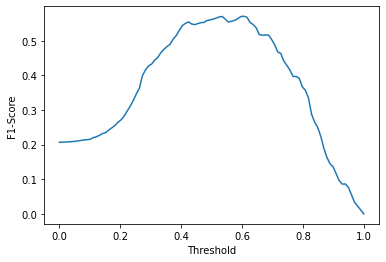

In [511]:
# Estimate prediction from model_last
y_pred = nlp_cats_predict(X_test, 'About', model_last)
print_scores(y_test, y_pred)

Accuracy score: 0.829
Precision score: 0.383
Recall score: 0.798
F-score: 0.518

Max F1-Score: 0.556 (threshold: 0.606)



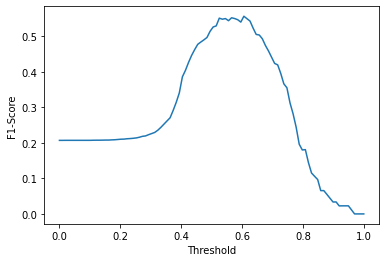

In [513]:
# Estimate prediction
y_pred = nlp_cats_predict(X_test, 'About', model_best)
print_scores(y_test, y_pred)

#### *Did try spacy models with a lemma, but it does wors resutls*